In [1]:
%matplotlib inline

In [2]:
import datetime
import numpy as np
import pylab
import eqcatalog
import eqcatalog.omori as omori
from ipy_render_html import render_html

In [70]:
reload(eqcatalog)
reload(omori)

<module 'eqcatalog.omori' from 'E:\Home\_kris\Python\seismo\eqcatalog\omori.py'>

In [3]:
cat = eqcatalog.rob.query_local_eq_catalog(start_date=1992, end_date=1992)

In [5]:
dc_method = eqcatalog.declustering.ClusterMethod()
#dc_window = eqcatalog.declustering.Gruenthal2009Window()
dc_window = eqcatalog.declustering.GardnerKnopoff1974Window()
Mrelation = {'ML': 'Ahorner1983'}

In [6]:
mainshock = cat.get_event_by_id(987)

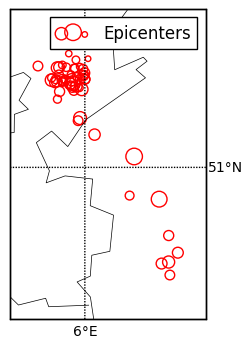

In [7]:
aftershocks = dc_method.get_aftershocks(mainshock, cat, dc_window, Mrelation)
aftershocks.plot_map()

In [8]:
aftershocks.print_info()

+-------------------+-------------------------+
|     Parameter     |          Value          |
+-------------------+-------------------------+
|    Catalog name   |                         |
| Earthquake number |            56           |
|     Start time    | 1992-04-13T01:22:53.000 |
|      End time     | 1992-11-04T03:56:01.000 |
|  Longitude bounds |     5.8688 / 6.2603     |
|  Latitude bounds  |    50.8100 / 51.2000    |
|    Depth range    |      8.0 / 24.0 km      |
|         ML        |  n=56, min=1.2, max=3.9 |
|    Event types    |        ke (n=56)        |
+-------------------+-------------------------+


In [9]:
render_html(aftershocks.print_list(as_html=True))

ID,Date,Time,Name,Lon,Lat,Z,ML
3596,1992-04-13,01:22:53,UETTERATH (DE),6.138,51.019,24.0,3.9
988,1992-04-13,01:31:08,ROERMOND (NL),5.927,51.163,15.6,2.1
989,1992-04-13,01:33:32,ROERMOND (NL),5.921,51.151,15.7,2.5
990,1992-04-13,01:46:03,ROERMOND(N),5.972,51.143,17.6,1.9
991,1992-04-13,01:53:30,ROERMOND(N),5.937,51.180,14.6,1.7
992,1992-04-13,02:02:24,ROERMOND(N),5.938,51.151,15.2,2.0
993,1992-04-13,02:04:31,ROERMOND(N),5.923,51.120,18.3,1.8
994,1992-04-13,02:05:07,MONTFORT(N),5.981,51.082,17.8,2.2
995,1992-04-13,02:08:20,ROERMOND(N),5.937,51.154,15.0,2.4
996,1992-04-13,02:30:40,ROERMOND(N),5.946,51.154,14.8,2.0


Determine cutoff magnitude

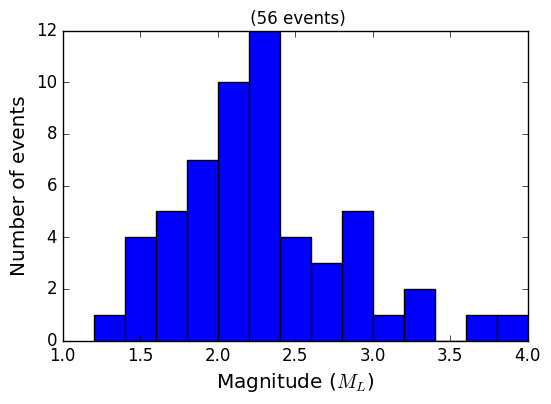

In [10]:
aftershocks.plot_Mhistogram(1.2, 4.0, 0.2, Mtype='ML', Mrelation={})

In [11]:
Mc = 2.2
aftershocks_Mc = aftershocks.subselect(Mmin=Mc)
aftershocks_Mc.print_info()

+-------------------+-------------------------+
|     Parameter     |          Value          |
+-------------------+-------------------------+
|    Catalog name   |        (subselect)      |
| Earthquake number |            44           |
|     Start time    | 1992-04-13T01:22:53.000 |
|      End time     | 1992-11-04T03:56:01.000 |
|  Longitude bounds |     5.8688 / 6.2603     |
|  Latitude bounds  |    50.8100 / 51.1782    |
|    Depth range    |      8.0 / 24.0 km      |
|         ML        |  n=44, min=1.9, max=3.9 |
|    Event types    |        ke (n=44)        |
+-------------------+-------------------------+


Fit aftershock rate (binned time intervals)

In [11]:
time_delta = np.timedelta64(12, 'h')
start_date = mainshock.datetime
end_date = mainshock.datetime + np.timedelta64(1, 'M').astype('m8[s]')

elapsed_time = aftershocks_Mc.start_date - mainshock.datetime
elapsed_time_delta = elapsed_time/time_delta
print(elapsed_time_delta)

observed_rate, bins_times = aftershocks_Mc.bin_by_time_interval(start_date, end_date, time_delta)
#delta_t1 = np.arange(len(bins_times)) + elapsed_time
delta_t1 = np.arange(len(bins_times)) + 0.5
print(observed_rate)

0.003958333333333334
[23.  3.  4.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  3.  1.  1.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


In [12]:
popt, perr = omori.OmoriLaw.fit_rate(delta_t1, observed_rate, initial_guess=(1,0.01, 1.2))
K, c, p = popt
print(K, c, p)
print(perr)

(7.566753831166596, 0.001000000000000257, 1.6054115802055573)
[4.56131416 0.29082185 0.48940756]


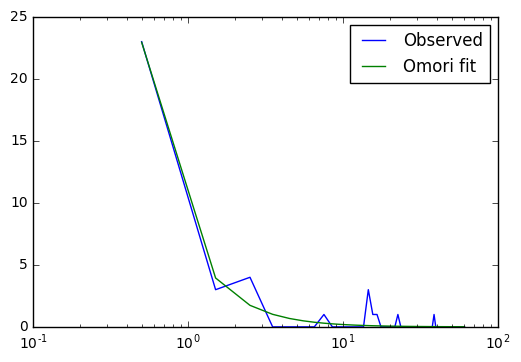

In [13]:
mol = omori.OmoriLaw(K, c, p, Mc)
pylab.semilogx(delta_t1, observed_rate, label='Observed')
predicted_rate = mol.get_aftershock_rate(delta_t1)
pylab.semilogx(delta_t1, predicted_rate, label='Omori fit')
pylab.legend()
pylab.show()

In [14]:
## Predicted number of aftershocks in 1 day
mol.get_num_aftershocks(2)

810.4286510041788

Fit aftershock rate (unbinned time interval)

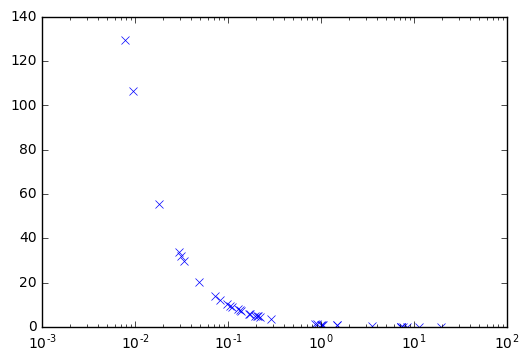

In [15]:
time_delta = np.timedelta64(1, 'D')
end_date = mainshock.datetime + np.timedelta64(1, 'M').astype('m8[s]')

aftershock_dts = aftershocks_Mc.get_datetimes()
delta_t2 = (aftershock_dts - mainshock.datetime) / time_delta
delta_t2 = delta_t2[aftershock_dts < end_date]

observed_rate = np.ones_like(delta_t2) / delta_t2
pylab.semilogx(delta_t2[1:], observed_rate[1:], 'x')
#print(delta_t1)
#print(observed_rate)

In [16]:
popt, perr = omori.OmoriLaw.fit_rate(delta_t2[1:], observed_rate[1:], initial_guess=(1,0.01, 1.2))
K, c, p = popt
print(K, c, p)
print(perr)

(0.8594781695342956, 0.0010000000000000002, 1.056317182487326)
[0.02632451 0.00018313 0.01066828]


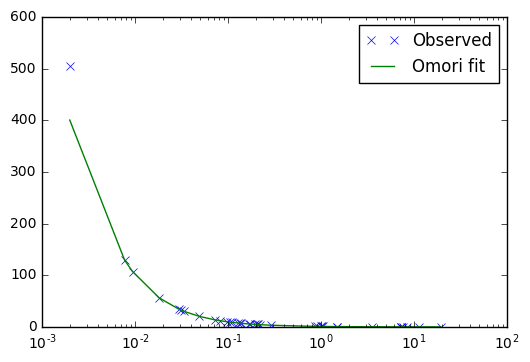

In [18]:
mol = omori.OmoriLaw(K, c, p, Mc)
pylab.semilogx(delta_t2, observed_rate, 'x', label='Observed')
predicted_rate = mol.get_aftershock_rate(delta_t2)
pylab.semilogx(delta_t2, predicted_rate, label='Omori fit')
pylab.legend()
pylab.show()

In [19]:
print(mol.get_num_aftershocks(1))

7.258286808274387


Fit cumulative number of aftershocks

In [20]:
observed_N = np.arange(1, len(delta_t2)+1)

In [21]:
popt, perr = omori.OmoriLaw.fit_cumulative(delta_t2, observed_N, initial_guess=(1, 0.01, 1.2))
K, c, p = popt
print(K, c, p)
print(perr)

(5.179465842152972, 0.056137838416010916, 1.3808808109800834)
[0.22673319 0.01531255 0.0889764 ]


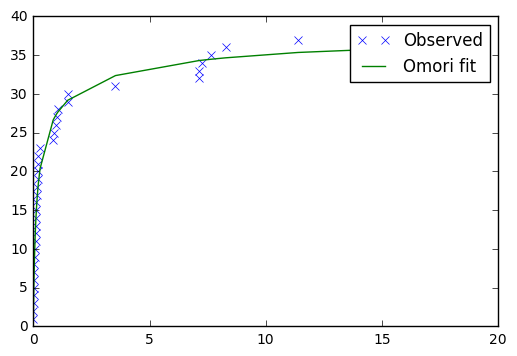

In [22]:
mol = omori.OmoriLaw(K, c, p, Mc)
pylab.plot(delta_t2, observed_N, 'x', label='Observed')
predicted_N = mol.get_num_aftershocks(delta_t2)
pylab.plot(delta_t2, predicted_N, label='Omori fit')
pylab.legend()
pylab.show()

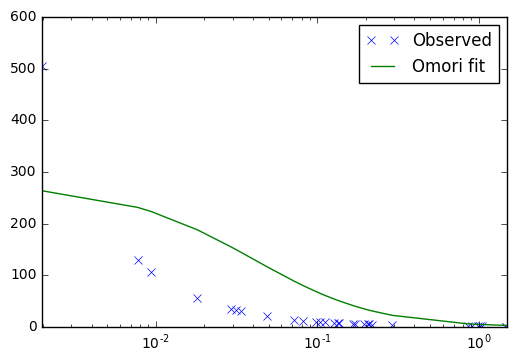

In [28]:
pylab.semilogx(delta_t2, observed_rate, 'x', label='Observed')
predicted_rate = mol.get_aftershock_rate(delta_t2)
pylab.semilogx(delta_t2, predicted_rate, label='Omori fit')
pylab.xlim(0, 1.5)
pylab.legend()
pylab.show()

In [29]:
print(mol.get_num_aftershocks(1))

27.40813027328575


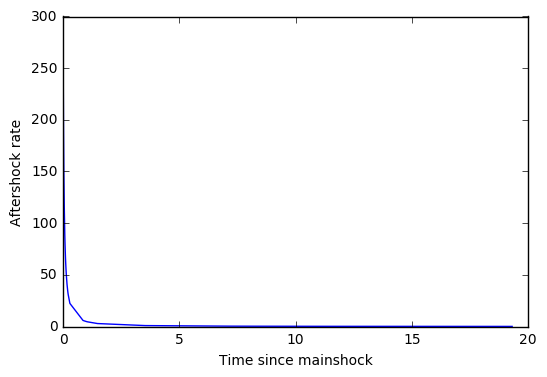

In [70]:
mol.plot_rate(delta_t2)

In [30]:
time_delta = np.timedelta64(1, 'D')
start_time = mainshock.datetime
end_date = mainshock.datetime + np.timedelta64(7, 'D').astype('m8[s]')
as_dts = aftershocks_Mc.get_datetimes()
delta_t3 = (as_dts - start_time) / time_delta
delta_t3 = delta_t3[as_dts <= end_date]
#print(delta_t3)

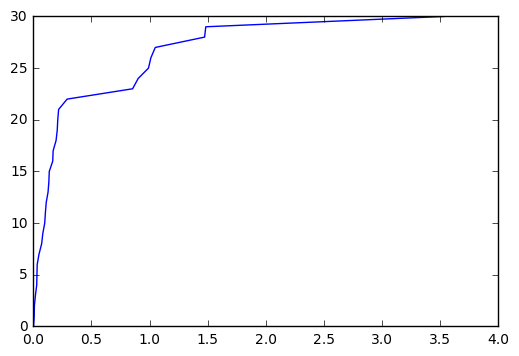

In [31]:
pylab.plot(delta_t3, range(len(delta_t3)))

In [78]:
(K, c, p) = eqcatalog.omori.estimate_omori_params(delta_t3, initial_guess=(0.001, 1.0),
                                                  minimize_method='Nelder-Mead', Ts=None,
                                                  bounds=((0.0001, 0.1), (0.1,2)), verbose=False)
print(K, c, p)

(4.858291441740856, 0.07771157782813741, 1.546118690690681)


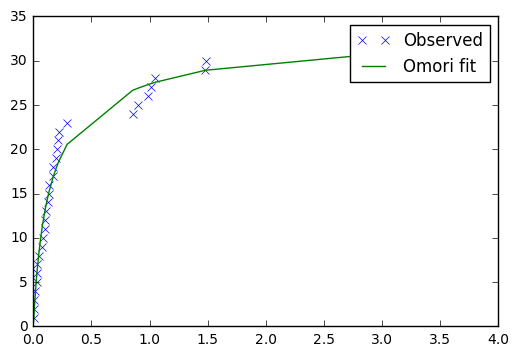

In [79]:
observed_N = np.arange(1, len(delta_t3)+1)
mol = omori.OmoriLaw(K, c, p, Mc)
pylab.plot(delta_t3, observed_N, 'x', label='Observed')
predicted_N = mol.get_num_aftershocks(delta_t3)
pylab.plot(delta_t3, predicted_N, label='Omori fit')
pylab.legend()
pylab.show()

In [80]:
print(mol.get_num_aftershocks(1))

27.362588723233028


Papers:
https://aees.org.au/wp-content/uploads/2015/06/4-Ghasemi-Hadi-Afterschock.pdf
http://www1.rcep.dpri.kyoto-u.ac.jp/~benescu/Work/Nanjo_et_al_JGR_2007.pdf